In [1]:
pwd

'/home/jslee/mammo_code'

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
from glob import glob
import numpy as np
from tqdm import tqdm
import re
import random
import csv 
import os
import function as f

In [4]:
import getfinal as f

In [5]:
# 모든 dicom 파일 불러오기 : 총 67749개의 파일
list_dicom = glob("dicom/*/*")
list_dicom.sort()
len(list_dicom)

67749

### dataset

In [9]:
# 1a, 1b에서 생성한 파일 불러오기
dicom = pd.read_csv("csv/dicom.csv",low_memory=False)
meta_total = pd.read_csv("csv/meta.csv")
density = pd.read_csv("csv/density_asan-ncc.csv")
density_samsung = pd.read_csv("csv/density_samsung.csv")

In [10]:
# file명으로부터 ID와 SIDE 정보
density["ID"] = [i.split("_")[0] for i in density.file]
density["SIDE"] = [i.split("_")[1] for i in density.file]

In [11]:
# 값을 LCC, RCC로 통일하기
meta_total.loc[(meta_total.SIDE_case == "1") | (meta_total.SIDE_case == "CCL") | (meta_total.SIDE_case == "L"),"SIDE_case"] = "LCC"
meta_total.loc[(meta_total.SIDE_case == "0") | (meta_total.SIDE_case == "CCR") | (meta_total.SIDE_case == "R"),"SIDE_case"] = "RCC"

In [12]:
# ID가 여러개인 대상자
list_change = meta_total[meta_total.ID.duplicated()].sort_values(["ID"]).ID.tolist()
meta_total[[i in list_change for i in meta_total.ID]]

,ID,GROUP,CENTER,AGE,BMI,SIDE_case
3685,33125750,control,ncc2018,42.0,NaN,NaN
3686,33125750,NaN,ncc2018,49.0,NaN,NaN
3732,20369037,control,ncc2018,56.0,NaN,NaN
3733,20369037,case,ncc2018,53.0,NaN,NaN
3738,20000686,control,ncc2018,62.0,NaN,NaN
...,...,...,...,...,...,...
5840,33297009,NaN,ncc2018,47.0,NaN,NaN
5881,33312764,NaN,ncc2018,63.0,NaN,NaN
5902,20416205,NaN,ncc2018,50.0,NaN,NaN
5904,33283138,NaN,ncc2018,38.0,NaN,NaN


In [13]:
# 일단 제외하기
meta_total = meta_total[[i not in list_change for i in meta_total.ID]]

In [14]:
# 위의 데이터 기준으로 다시 파일 정리
dicom = dicom.merge(meta_total,how="left")
density = meta_total.merge(density,how="right")

In [15]:
# case의 반대쪽만 선택하기
dicom_case = dicom[(dicom.GROUP=="case") & ((dicom.LR=="LCC") | (dicom.LR=="RCC")) & ~pd.isna(dicom.SIDE_case)]
dicom_control = dicom[(dicom.GROUP=="control") & ((dicom.LR=="LCC") | (dicom.LR=="RCC"))]
density_case = density[(density.GROUP=="case") & (density.SIDE!=density.SIDE_case)]
density_control = density[(density.GROUP=="control")]
density_case = density_case[density_case.SIDE_case != "BOTH"]

In [16]:
# 파일 확인하기

In [17]:
density_control[density_control.CENTER=="asan"]

,ID,GROUP,CENTER,AGE,BMI,SIDE_case,file,thres_cu,thres_ac,thres_cc,darea_cu,darea_ac,darea_cc,pda_cu,pda_ac,pda_cc,SIDE
0,10512416,control,asan,44.0,20.82,NaN,10512416_RCC_20070829.dcm,2132.868925,2200.056425,2490.681425,23.614600,19.1429,0.9192,35.13160,27.281200,1.293060,RCC
2,10531695,control,asan,55.0,21.841,NaN,10531695_RCC_20090205.dcm,2327.620166,2393.245166,2813.557666,8.285550,6.7282,0.2296,17.44700,13.631600,0.461143,RCC
4,10532852,control,asan,49.0,19.453,NaN,10532852_LCC_20071214.dcm,2179.805586,2267.305586,2562.618086,24.510100,20.2968,1.1495,36.30340,29.103900,1.622840,LCC
5,10548701,control,asan,50.0,21.51,NaN,10548701_LCC_20071212.dcm,2357.944157,2439.194157,2742.319157,15.300650,8.9198,0.3744,21.01330,11.666600,0.483583,LCC
6,10554131,control,asan,48.0,25.215,NaN,10554131_RCC_20071205.dcm,2448.720291,2528.407791,3342.470291,17.328300,10.6251,0.2489,21.60520,12.524600,0.294524,RCC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1631,36088814,control,asan,58.0,25.11,NaN,36088814_LCC_20080219.dcm,2345.434845,2421.997345,2739.184845,19.604050,14.0123,0.5981,25.50645,17.743900,0.742432,LCC
1676,36347582,control,asan,58.0,24.789,NaN,36347582_LCC_20080411.dcm,2216.511774,2299.324274,2660.261774,19.117650,12.6672,0.3635,12.47440,7.850070,0.225251,LCC
1782,36736384,control,asan,55.0,20.118,NaN,36736384_LCC_20080905.dcm,2318.635246,2412.385246,2649.885246,7.826815,4.2798,0.2551,7.16803,3.712700,0.222192,LCC
1847,36955091,control,asan,55.0,21.785,NaN,36955091_LCC_20081113.dcm,2367.198998,2468.761498,2804.698998,18.714350,10.4572,0.2555,14.79840,7.820290,0.191072,LCC


In [18]:
density_control[density_control.CENTER=="ncc2020"]

,ID,GROUP,CENTER,AGE,BMI,SIDE_case,file,thres_cu,thres_ac,thres_cc,darea_cu,darea_ac,darea_cc,pda_cu,pda_ac,pda_cc,SIDE
3210,21459,control,ncc2020,56.0,NaN,NaN,21459_RCC_19000101.dcm,2400.5,2552.5,2763.0,22.879470,5.481308,0.678147,17.492790,4.189932,0.517929,RCC
3211,21460,control,ncc2020,55.0,NaN,NaN,21460_LCC_19000101.dcm,2501.5,2693.0,2913.0,13.016930,3.711574,0.578329,20.088030,5.726939,0.892358,LCC
3212,21460,control,ncc2020,55.0,NaN,NaN,21460_RCC_19000101.dcm,2302.5,2459.5,2672.5,12.294430,4.120676,0.416406,22.476930,7.532742,0.761204,RCC
3213,21463,control,ncc2020,72.0,NaN,NaN,21463_LCC_19000101.dcm,2529.5,2619.0,2750.0,10.955220,2.684835,0.435041,10.636960,2.626159,0.424377,LCC
3214,21463,control,ncc2020,72.0,NaN,NaN,21463_RCC_19000101.dcm,2532.0,2651.0,2866.0,8.409958,1.975171,0.291179,8.034418,1.901855,0.280370,RCC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14113,25667,control,ncc2020,64.0,NaN,NaN,25667_RCC_19000101.dcm,1934.0,2708.0,3456.0,18.487550,2.823919,0.401114,20.555580,3.139804,0.445983,RCC
14114,25669,control,ncc2020,56.0,NaN,NaN,25669_LCC_19000101.dcm,1701.0,2362.0,3364.0,17.140640,4.889416,0.866320,24.138910,6.885692,1.220026,LCC
14115,25669,control,ncc2020,56.0,NaN,NaN,25669_RCC_19000101.dcm,1538.0,2486.0,3478.0,19.050120,4.342184,0.723681,26.391970,6.015646,1.002585,RCC
14116,25672,control,ncc2020,50.0,NaN,NaN,25672_LCC_19000101.dcm,1728.0,2670.0,3407.0,15.619730,2.584162,0.557326,18.946750,3.134592,0.676037,LCC


In [19]:
density_control[density_control.ID=="21459"] 
# 원본에는 21459가 붙어있는데 다시 돌리니 떨어져있어나오지만 결국 2개 다 있음.

,ID,GROUP,CENTER,AGE,BMI,SIDE_case,file,thres_cu,thres_ac,thres_cc,darea_cu,darea_ac,darea_cc,pda_cu,pda_ac,pda_cc,SIDE
3210,21459,control,ncc2020,56.0,NaN,NaN,21459_RCC_19000101.dcm,2400.5,2552.5,2763.0,22.87947,5.481308,0.678147,17.49279,4.189932,0.517929,RCC
5081,21459,control,ncc2020,56.0,NaN,NaN,21459_LCC_19000101.dcm,2391.5,2528.0,2717.0,24.23881,6.466526,0.539950,18.20697,4.858516,0.406043,LCC


In [20]:
density_samsung

,ID,SIDE,GROUP,thres_cu,thres_ac,thres_cc,darea_cu,darea_ac,darea_cc,pda_cu,pda_ac,pda_cc,CENTER
0,3625515,CCL,0,2328.144813,2462.519813,2635.957313,5.899175,2.014850,0.611775,8.161189,2.768734,0.838834,samsung
1,29165253,CCL,1,2641.750071,2830.812571,3046.437571,22.884150,7.497425,1.036800,17.221370,5.636589,0.790817,samsung
2,11587757,CCL,0,2309.209125,2470.146625,2621.709125,21.629350,7.934875,0.933825,29.619130,11.048340,1.279247,samsung
3,6449235,CCR,0,2331.813849,2478.688849,2605.251349,18.672850,6.820000,1.471800,25.574420,9.340616,2.007620,samsung
4,27422082,CCL,1,2241.394942,2374.207442,2489.832442,18.615770,4.702700,1.140500,13.150960,3.331193,0.797089,samsung
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2061,24861037,NaN,1,NaN,NaN,NaN,26.869540,32.193590,5.718840,27.303770,32.086980,5.696680,samsung
2062,119826,NaN,1,NaN,NaN,NaN,9.457800,5.827342,1.476760,7.537513,4.999401,1.270410,samsung
2063,3303121,NaN,1,NaN,NaN,NaN,14.535750,13.964560,1.994590,13.872880,12.991380,1.855950,samsung
2064,7978509,NaN,1,NaN,NaN,NaN,14.558440,15.909520,2.350820,13.832670,14.541730,2.143350,samsung


### preprocessing

#### with threshold

In [21]:
# density label이 있는 것들

In [22]:
import pydicom

def get_dicom(path):
    dicom = pydicom.read_file(path, force=True, stop_before_pixels=False)
    return dicom

11047 dicom/ncc2020/22733_RCC_19000101.dcm HOLOGIC, Inc.


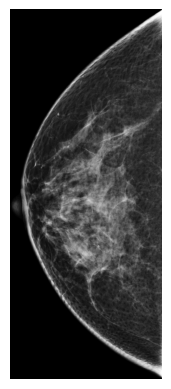

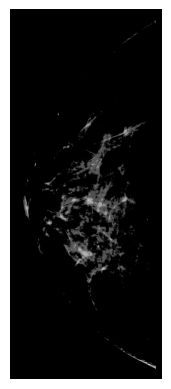

[100.0, 9.304585290990705, 1.052802543201458, 0.015919190160570224]
pda_cu    12.99696
pda_ac    3.040483
pda_cc    0.468021
Name: 11047, dtype: object


In [28]:
#11047 
i=11047 
file = "dicom/"+density.loc[i,"CENTER"]+"/"+density.loc[i,"file"]
thres = [density.loc[i,"thres_cu"],density.loc[i,"thres_ac"],density.loc[i,"thres_cc"]]
dicom = f.get_dicom(file) 
#dicom = pydicom.read_file(file, force=True, stop_before_pixels=False)
vendor = dicom.Manufacturer
print(i, file, vendor)

final = f.get_final5(file, thres = thres)
f.p(final[0])
f.p(final[1])
print(final[2]['percent'])
print(density.loc[i,["pda_cu","pda_ac","pda_cc"]])

8208 dicom/ncc2020/20006_LCC_19000101.dcm HOLOGIC, Inc.


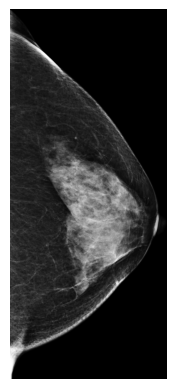

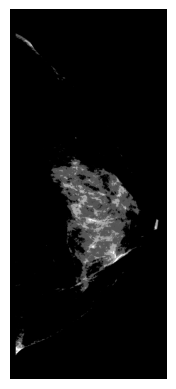

[100.0, 16.781993626578355, 3.6511855631666346, 0.21109735422378287]
pda_cu    19.39517
pda_ac     4.52226
pda_cc     0.55727
Name: 8208, dtype: object


In [27]:
# 아무거나 확인해보기
#i = random.choice(list(range(14117)))
i=10544
file = "dicom/"+density.loc[i,"CENTER"]+"/"+density.loc[i,"file"]
thres = [density.loc[i,"thres_cu"],density.loc[i,"thres_ac"],density.loc[i,"thres_cc"]]
dicom = f.get_dicom(file) 
#dicom = pydicom.read_file(file, force=True, stop_before_pixels=False)
vendor = dicom.Manufacturer
print(i, file, vendor)

final = f.get_final5(file, thres = thres)
f.p(final[0])
f.p(final[1])
print(final[2]['percent'])
print(density.loc[i,["pda_cu","pda_ac","pda_cc"]])

In [18]:
# process과정에서 계산한 값들을 저장하기 위한 파일
header = ['file','pixel_ta', 'pixel_cu', 'pixel_ac', 'pixel_cc', 'area_ta', 'area_cu', 'area_ac', 'area_cc', 'percent_ta', 'percent_cu','percent_ac','percent_cc']  
with open('numpy.csv', 'w') as result: 
    write = csv.writer(result)
    write.writerow(header) 

In [19]:
for i in tqdm(range(len(density))):
    try:
        file = "dicom/"+density.loc[i,"CENTER"]+"/"+density.loc[i,"file"]
        thres = [density.loc[i,"thres_cu"],density.loc[i,"thres_ac"],density.loc[i,"thres_cc"]]
        final = f.get_final5(file, thres = thres)

        np.save(re.sub(".dcm",".npy",re.sub("dicom","numpy/image",file)), final[0])
        np.save(re.sub(".dcm",".npy",re.sub("dicom","numpy/segment",file)), final[1])

        with open('numpy.csv', 'a') as result: 
            write = csv.writer(result)
            write.writerow([file] + final[2]['pixel'] + final[2]['area'] + final[2]['percent'])
    except:
        pass

100%|██████████| 14118/14118 [5:25:21<00:00,  1.38s/it]  


#### without label

In [45]:
# density label 없는 아이들 -> only classification OR density prediction

dicom/brmh/0896_RCC_20190729.dcm HOLOGIC, Inc.


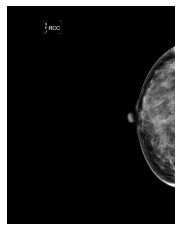

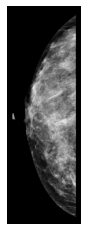

In [689]:
file = random.choice(list_dicom)
dicom = f.get_dicom(file)
print(file, vendor)

final = f.get_final5(file, removed=True)
f.p(f.get_image(dicom))
f.p(final)

In [60]:
tmp = density.file.tolist()
list_dicom_wo_label = [i for i in list_dicom if i.split('/')[-1] not in tmp]
list_dicom_wo_label = [i for i in list_dicom_wo_label if "MLO" not in i]

In [82]:
len(list_dicom_wo_label)

29542

In [85]:
list_ilsan = [i for i in list_dicom_wo_label if "ilsan" in i]
for i in tqdm(range(len(list_ilsan))):    
    try:
        file = list_ilsan[i]
        image = re.sub(".dcm",".npy",re.sub("dicom","numpy/image",file))
        if os.path.exists(image) is False:
            final = f.get_final5(file)
            np.save(image, final)
    except:
        pass

100%|██████████| 298/298 [03:03<00:00,  1.63it/s]


In [116]:
list_ncc2020 = [i for i in list_dicom_wo_label if "ncc2020" in i]
for i in tqdm(range(len(list_ncc2020))):    
    try:
        file = list_ncc2020[i]
        image = re.sub(".dcm",".npy",re.sub("dicom","numpy/image",file))
        if os.path.exists(image) is False:
            final = f.get_final5(file)
            np.save(image, final)
    except:
        pass

100%|██████████| 3000/3000 [1:09:07<00:00,  1.38s/it]


In [118]:
list_twin = [i for i in list_dicom_wo_label if "twin" in i]
for i in tqdm(range(len(list_twin)), miniters=50):    
    try:
        file = list_twin[i]
        image = re.sub(".dcm",".npy",re.sub("dicom","numpy/image",file))
        if os.path.exists(image) is False:
            final = f.get_final5(file)
            np.save(image, final)
    except:
        pass

100%|██████████| 1813/1813 [10:14<00:00,  2.95it/s]


In [119]:
list_ncc2018 = [i for i in list_dicom_wo_label if "ncc2018" in i]
for i in tqdm(range(len(list_ncc2018)), miniters=50, mininterval=5):    
    try:
        file = list_ncc2018[i]
        image = re.sub(".dcm",".npy",re.sub("dicom","numpy/image",file))
        if os.path.exists(image) is False:
            final = f.get_final5(file)
            np.save(image, final)
    except:
        pass

100%|██████████| 4281/4281 [39:41<00:00,  1.80it/s]


In [120]:
list_samsung = [i for i in list_dicom_wo_label if "samsung" in i]
for i in tqdm(range(len(list_samsung)), miniters=50, mininterval=5):
    try:
        file = list_samsung[i]
        image = re.sub(".dcm",".npy",re.sub("dicom","numpy/image",file))
        if os.path.exists(image) is False:
            final = f.get_final5(file)
            np.save(image, final)
    except:
        pass

100%|██████████| 15646/15646 [2:24:47<00:00,  1.80it/s]  


In [121]:
list_asan = [i for i in list_dicom_wo_label if "asan" in i]
for i in tqdm(range(len(list_asan)), miniters=50, mininterval=5):
    try:
        file = list_asan[i]
        image = re.sub(".dcm",".npy",re.sub("dicom","numpy/image",file))
        if os.path.exists(image) is False:
            final = f.get_final5(file)
            np.save(image, final)
    except:
        pass

100%|██████████| 1667/1667 [07:41<00:00,  3.61it/s]


In [122]:
list_brmh = [i for i in list_dicom_wo_label if "brmh" in i]
for i in tqdm(range(len(list_brmh)), miniters=50, mininterval=5):
    try:
        file = list_brmh[i]
        image = re.sub(".dcm",".npy",re.sub("dicom","numpy/image",file))
        if os.path.exists(image) is False:
            final = f.get_final5(file)
            np.save(image, final)
    except:
        pass

100%|██████████| 2837/2837 [27:18<00:00,  1.73it/s]


#### retrain

In [47]:
# 확인용?

In [33]:
header = ['file','pixel_ta', 'pixel_cu', 'pixel_ac', 'pixel_cc', 'area_ta', 'area_cu', 'area_ac', 'area_cc', 'percent_ta', 'percent_cu','percent_ac','percent_cc']  
with open('numpy3.csv', 'w') as result: 
    write = csv.writer(result)
    write.writerow(header) 

In [34]:
tmp = pd.read_csv("csv/train.csv")
tmp = tmp[tmp.dataset_density=="yes"].merge(density, on=['file','CENTER'])

In [35]:
tmp

,dataset,dataset_density,dataset_image,file_image,file,CENTER,ID_x,DATE,SIDE_x,SIDE_case_x,...,thres_cu,thres_ac,thres_cc,darea_cu,darea_ac,darea_cc,pda_cu,pda_ac,pda_cc,SIDE_y
0,train,yes,yes,numpy/image_256x256/asan/10512416_RCC_20070829...,10512416_RCC_20070829.dcm,asan,10512416,20070829.dcm,RCC,NaN,...,2132.868925,2200.056425,2490.681425,23.614600,19.142900,0.919200,35.131600,27.281200,1.293060,RCC
1,val,yes,yes,numpy/image_256x256/asan/10516254_LCC_20080709...,10516254_LCC_20080709.dcm,asan,10516254,20080709.dcm,LCC,RCC,...,2362.077590,2457.390090,2768.327590,27.638500,19.474200,1.277500,24.497100,16.404300,1.088320,LCC
2,cal,yes,yes,numpy/image_256x256/asan/10531695_RCC_20090205...,10531695_RCC_20090205.dcm,asan,10531695,20090205.dcm,RCC,NaN,...,2327.620166,2393.245166,2813.557666,8.285550,6.728200,0.229600,17.447000,13.631600,0.461143,RCC
3,train,yes,yes,numpy/image_256x256/asan/10531811_LCC_20080218...,10531811_LCC_20080218.dcm,asan,10531811,20080218.dcm,LCC,RCC,...,2395.471939,2526.721939,2645.471939,4.773915,0.946300,0.160500,3.534435,0.634850,0.107260,LCC
4,train,yes,yes,numpy/image_256x256/asan/10548701_LCC_20071212...,10548701_LCC_20071212.dcm,asan,10548701,20071212.dcm,LCC,NaN,...,2357.944157,2439.194157,2742.319157,15.300650,8.919800,0.374400,21.013300,11.666600,0.483583,LCC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8077,train,yes,no,numpy/image_256x256/ncc2020/25653_LCC_19000101...,25653_LCC_19000101.dcm,ncc2020,25653,19000101.dcm,LCC,NaN,...,1755.000000,2205.000000,3158.000000,10.017610,2.180647,0.156114,4.464718,0.996341,0.071329,LCC
8078,train,yes,no,numpy/image_256x256/ncc2020/25654_RCC_19000101...,25654_RCC_19000101.dcm,ncc2020,25654,19000101.dcm,RCC,NaN,...,2593.000000,2751.000000,2973.000000,9.733143,1.612725,0.284052,16.345780,2.709688,0.475775,RCC
8079,val,yes,no,numpy/image_256x256/ncc2020/25661_LCC_19000101...,25661_LCC_19000101.dcm,ncc2020,25661,19000101.dcm,LCC,NaN,...,1739.000000,2600.000000,3277.000000,33.900500,7.687414,2.022230,18.030120,4.088582,1.075531,LCC
8080,train,yes,no,numpy/image_256x256/ncc2020/25666_RCC_19000101...,25666_RCC_19000101.dcm,ncc2020,25666,19000101.dcm,RCC,NaN,...,1809.000000,2719.000000,3450.000000,24.998040,5.948453,1.376312,26.372270,6.275463,1.451973,RCC


In [ ]:
name = 'numpy3.csv'
for i in tqdm(range(len(tmp)),mininterval=5, miniters=50):
    try:
        file = "dicom/"+tmp.loc[i,"CENTER"]+"/"+tmp.loc[i,"file"]
        thres = [tmp.loc[i,"thres_cu"],tmp.loc[i,"thres_ac"],tmp.loc[i,"thres_cc"]]
        final = f.get_final5(file, thres = thres)

        np.save(re.sub(".dcm",".npy",re.sub("dicom","numpy2/image",file)), final[0])
        np.save(re.sub(".dcm",".npy",re.sub("dicom","numpy2/segment",file)), final[1])

        with open(name, 'a') as result: 
            write = csv.writer(result)
            write.writerow([file] + final[2]['pixel'] + final[2]['area'] + final[2]['percent'])
    except:
        pass

 26%|██▌       | 2110/8082 [20:13<1:51:07,  1.12s/it]

#### examples

In [ ]:
# 예시 파일 아무거나 확인

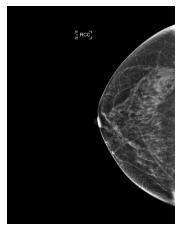

In [29]:
f.p(f.get_image("dicom/ncc2020/21246_RCC_19000101.dcm"))

9531 dicom/ncc2020/21246_RCC_19000101.dcm HOLOGIC, Inc.


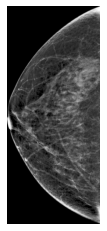

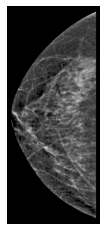

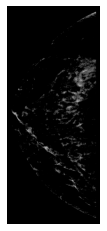

[100.0, 8.89771721771165, 0.8082876828092223, 0.004247961656271212]
pda_cu    13.4481
pda_ac    3.33191
pda_cc     1.2014
Name: 9531, dtype: object


In [554]:
#i = random.choice(list(range(14117)))
file = "dicom/"+density.loc[i,"CENTER"]+"/"+density.loc[i,"file"]
thres = [density.loc[i,"thres_cu"],density.loc[i,"thres_ac"],density.loc[i,"thres_cc"]]
dicom = f.get_dicom(file)
vendor = dicom.Manufacturer
print(i, file, vendor)
gmm = gmm_GE if "GE" in vendor else gmm_HO
scale = scaling_GE if "GE" in vendor else scaling_GE
final = f.get_final5(file, gmm)
final2 = f.get_final5(file, gmm, thres, removed=True)
f.p(final)
f.p(final2[0])
f.p(final2[1])
print(final2[2]['percent'])
print(density.loc[i,["pda_cu","pda_ac","pda_cc"]])

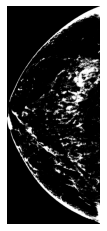

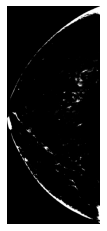

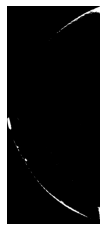

In [561]:
f.p(final>thres[0])
f.p(final>thres[1])
f.p(final>thres[2])

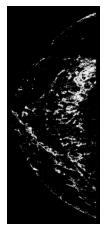

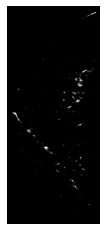

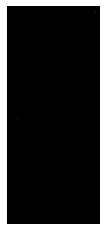

In [564]:
f.p(final2[1]==1)
f.p(final2[1]==2)
f.p(final2[1]==3)

7184 dicom/ncc2020/00011_LCC_19000101.dcm HOLOGIC, Inc.


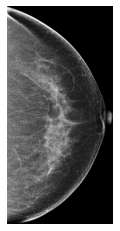

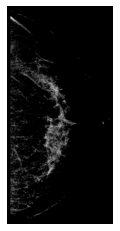

[174.272861, 23.440032000000006, 2.3095660000000002, 0.019502000000000005]
[100.0, 13.450190618033178, 1.3252585553180307, 0.011190497411986598]
darea_cu     30.6563
darea_ac     4.96409
darea_cc    0.931098
Name: 7184, dtype: object


In [32]:
file = "dicom/ncc2020/00011_LCC_19000101.dcm"
i = 7184
thres = [density.loc[i,"thres_cu"],density.loc[i,"thres_ac"],density.loc[i,"thres_cc"]]
dicom = f.get_dicom(file)
vendor = dicom.Manufacturer
print(i, file, vendor)

final = f.get_final5(file, thres = thres)
f.p(final[0])
f.p(final[1])
print(final[2]['area'])
print(final[2]['percent'])
print(density.loc[i,["darea_cu","darea_ac","darea_cc"]])

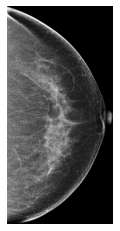

In [72]:
f.p(final[0])

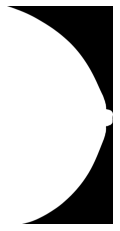

In [73]:
f.p(f.get_final5(file)!=0)

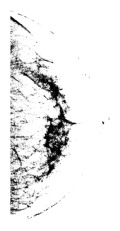

In [74]:
f.p(final[1]==0)

In [75]:
final[2]

{'pixel': [3556589, 478368, 47134, 398],
 'area': [248.96123, 33.48576, 3.29938, 0.027860000000000003],
 'percent': [100.0,
  13.450190618033178,
  1.3252585553180307,
  0.011190497411986598]}

In [79]:
tmp = pd.read_csv("numpy.csv")
tmp[tmp.file==file]

,file,pixel_ta,pixel_cu,pixel_ac,pixel_cc,area_ta,area_cu,area_ac,area_cc,percent_ta,percent_cu,percent_ac,percent_cc
7135,dicom/ncc2020/00011_LCC_19000101.dcm,3252813,473666,46934,398,227.69691,33.15662,3.28538,0.02786,100.0,14.561735,1.442874,0.012236
